# Optimal Advertising

This notebook is a Python implementation of the Optimal Advertising exercise.

You can find example instances on the course's Moodle page. (No ads are shown there; we are still working on monetization. :) )

## Problem Statement

Suppose you own a website where you can display ads. Your site is incredibly successful, so you get a consistent number of users $T_{t}$ visiting your webpage at time $t = 1, 2, \dots, n$ each day. Because of the success, you signed contracts with $m$ companies, agreeing to show ads of each company $i = 1, 2, \dots, m$ at least $c_{i}$ times per day. However, you can display at most one ad per each visit of your page.

1. Suppose that for every company $i$ and time slot $t$ you know the probability $P_{it}$ of a user visiting your website at time $t$ clicking an ad for company $i$ (i.e., the click rate). Assume that company $i$ pays you $p_{i}$ whenever their ad generates a click. Naturally, you would like to decide so that your ad revenue is maximized. For the sake of simplicity, you may assume that the number of times $D_{it}$ that you show ads for company $i$ in timeslot $t$ does not need to be integral. (If the $T_{t}$ are large (and your website attracts a lot of traffic!), this simplifying assumption will not affect the result significantly.) Model this optimization problem as a linear program and solve it with CVXPY.

1. Now suppose that each company $i$ has set a maximum daily advertisement budget $B_{i}$, which caps the amount of money they will pay you each day for displaying their ads. Prove that the corresponding objective function is concave (and thus can be maximized over). Model the modified problem as a convex program and solve it with CVXPY.

1. Now suppose that there are no daily revenue caps, but every $D_{it}$ has to be integral. Model the problem as an integer program and solve it with CVXPY. (Note that the resulting formulation is <b>not</b> a convex optimization program.) Use `cp.Variable(dimensions, integer=True)` to create the variables. Observe the differences in how much time it takes to solve each variant of the problem. Do not worry if large instances take too long.

## Implementation

First let us import all the packages we will use later.

In [4]:
import numpy as np  # for number manipulation
import matplotlib.pyplot as plt  # for plotting
import cvxpy as cp  # for optimization

### Importing Example Instances

Next let us implement a function that parses the input file. The format of the input file is as follows.

* The first line contains the number of companies and the number of time slots.
* The second line contains the number of visitors in each time slot.
* The thrid line lists the minimum ad quotas from each company.
* The fourth line shows how much each company pays per click of their ad.
* The fifth line contains daily budget caps for each company (from the second subproblem).
* The remaining lines list the click probabilities of ads of each company in each time slot (with each line representing one company).

In [5]:
# Converts string into list of floats
def to_float_list(string):
    return [float(word) for word in string.strip().split(' ')]


# Parses data file and returns lists containing instance data
def parse_file(filename):
    with open(filename) as f:
        dims = to_float_list(f.readline())
        m, n = int(dims[0]), int(dims[1])
        traffic = to_float_list(f.readline())
        minimum_times_shown = to_float_list(f.readline())
        payment_per_click = to_float_list(f.readline())
        max_payment = to_float_list(f.readline())
        click_probabilities = [to_float_list(line) for line in f]
    return m, n, traffic, minimum_times_shown, payment_per_click, max_payment, click_probabilities

In [6]:
# Import problem instance from file
m, n, traffic, minimum_times_shown, payment_per_click, max_payment, click_probabilities = \
    parse_file('Optimal_Ads_4.txt')  # filename can be between 'Optimal_Ads_1.txt' and 'Optimal_Ads_4.txt'
print("companies", m)
print("timeslots", n) 

companies 15
timeslots 100


### LP Formulation

Now we can create and solve our LP model. Note that the `@` symbol represents matrix multiplication and that vector inequalities are evaluated component-wise.

In [7]:
# Create and solve model
D = cp.Variable((m,n))
P = click_probabilities
p = payment_per_click
money_it = np.array([np.array(P[i])*np.array(p[i]) for i in range(m)])

objective = cp.Maximize(cp.sum(cp.multiply(D,money_it)))
constraints = [np.ones((1,m))@D<=traffic,
               D@np.ones((n,1))>=minimum_times_shown,
               D >= 0]

prob = cp.Problem(objective, constraints)
prob.solve()

# Print optimal solution
print(f'Total income: {prob.value}\n' +
      f'Assignment for each company: {[]}')

Total income: 4309982.731682228
Assignment for each company: []


### Capped Payments

Next, to take into account the ad budget caps, we simply modify the objective function as described in the theoretical solution. Note that the solver is able to handle the resulting model, since it is a concave maximization problem.

In [8]:
# Create and solve model
D_cap = cp.Variable((m,n))

P = click_probabilities
p = payment_per_click
money_it = np.array([np.array(P[i])*np.array(p[i]) for i in range(m)])
max_payment = np.array(max_payment).reshape(m, 1)

capped_money = cp.multiply(D_cap,money_it)@np.ones((n,1))

constraints_cap = [np.ones((1,m))@D_cap<=traffic,
               D_cap@np.ones((n,1))>=minimum_times_shown,
               D_cap >= 0]

prob_cap = cp.Problem(cp.Maximize(np.ones((1,m))@(cp.minimum(capped_money,max_payment))), constraints_cap)
prob_cap.solve()

# Print optimal solution
print(f'Total income: {prob_cap.value}\n' +
      f'Assignment for each company: {[]}')

Total income: 184053.41834924516
Assignment for each company: []


### Comparison of Uncapped and Capped Variants

Below we compare the uncapped and capped variants of the problem by plotting the distribution of the ads shown for each company.

Observe that with no budget caps, almost all visitors get ads of just one company, namely the one with the highest expected payment per click. Thus, in this setting the best strategy is to satisfy the minimum quota for all companies and allot the remaining capacity to the company that pays the most, which is intuitively a good strategy. In contrast, if budget caps are introduced, the diversity of companies for which we display ads becomes larger. This makes sense, as we can no longer show ads for the highest-paying company indefinitely.

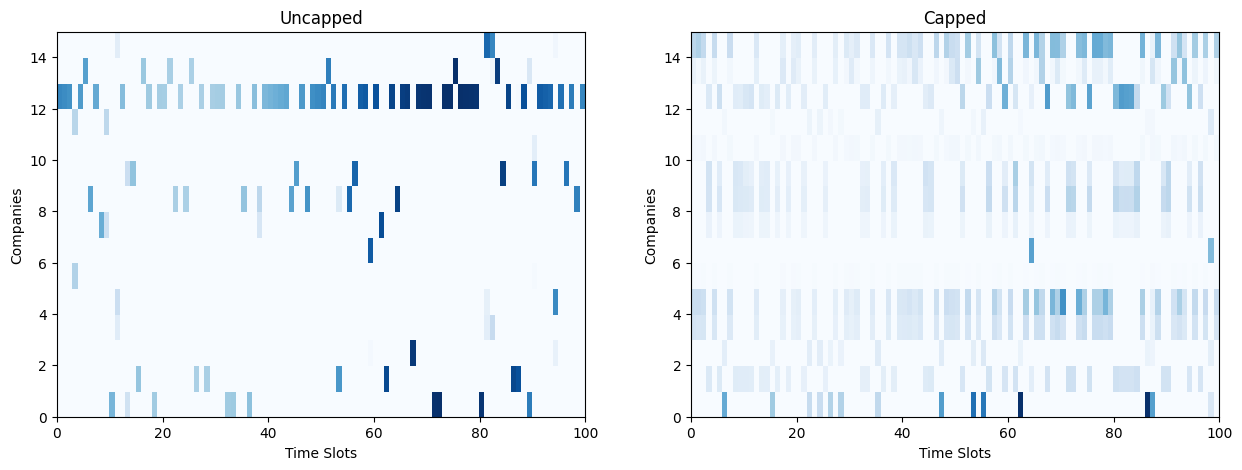

In [9]:
# Create two subplots side-by-side
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plot heat map for uncapped problem
ax[0].pcolor(D.value, cmap=plt.cm.Blues)
ax[0].set_title('Uncapped')
ax[0].set_ylabel('Companies')
ax[0].set_xlabel('Time Slots')

# Plot heat map for capped problem
ax[1].pcolor(D_cap.value, cmap=plt.cm.Blues)
ax[1].set_title('Capped')
ax[1].set_ylabel('Companies')
ax[1].set_xlabel('Time Slots')

# Display complete plot
plt.show()

### Integrality Constraints

Adding integrality constraints to our model can be done simply by specifying the option `integer=True` when creating the variables that need to be integral.

In [10]:
# Create and solve model
# Create and solve model
D_int = cp.Variable((m,n), integer=True)
P = click_probabilities
p = payment_per_click
money_it = np.array([np.array(P[i])*np.array(p[i]) for i in range(m)])

objective_int = cp.Maximize(cp.sum(cp.multiply(D_int,money_it)))
constraints_int = [np.ones((1,m))@D_int<=traffic,
               D_int@np.ones((n,1))>=minimum_times_shown,
               D_int >= 0]
prob_int = cp.Problem(objective_int, constraints_int)
prob_int.solve(solver=cp.GLPK_MI)

# Print optimal solution
print(f'Total income: {prob_int.value}\n' +
      f'Assignment for each company: {[]}')

Total income: 4309983.054456311
Assignment for each company: []


In [11]:
print(cp.installed_solvers())

['CLARABEL', 'CVXOPT', 'GLPK', 'GLPK_MI', 'OSQP', 'SCIPY', 'SCS']
